## Project Setup: Video Game Review Score Prediction

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install sentence-transformers gensim scipy

In [ ]:
# --- Essential Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Text Vectorization ---
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

# --- Machine Learning & Evaluation ---
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# --- General Setup ---
# Download tokenizer data for Word2Vec
for resource in ["punkt", "punkt_tab"]:
    try:
        nltk.data.find(f"tokenizers/{resource}")
    except LookupError:
        nltk.download(resource)


# Set a consistent style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported and environment set up successfully.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Libraries imported and environment set up successfully.


In [ ]:
# Load the datasets
try:
    labeled_df = pd.read_csv('labeled-data.csv')
    unlabeled_df = pd.read_csv('unlabeled-data.csv')
except FileNotFoundError:
    print("Make sure 'labeled_reviews.csv' and 'unlabeled_reviews.csv' are in the same directory.")

print("--- Labeled Data ---")
print(f"Shape: {labeled_df.shape}")
print(labeled_df.head())
print("\n--- Unlabeled Data ---")
print(f"Shape: {unlabeled_df.shape}")
print(unlabeled_df.head())

# Combine text from both for training word embeddings
all_text = pd.concat([labeled_df['review_text'], unlabeled_df['review_text']], ignore_index=True)
print(f"\nTotal number of review texts for vectorization: {len(all_text)}")

--- Labeled Data ---
Shape: (1250, 2)
                                         review_text  review_score
0  It&#146;s the best looking, most enticingly pu...             8
1  The Nintendo LABO Variety Kit has some fun and...             8
2  But as far as sound investments go, buying up ...             8
3  Starts out with a bang, but then quickly falls...             7
4  Valkyria Revolution tells a decent tale of war...             6

--- Unlabeled Data ---
Shape: (5000, 2)
                                         review_text  review_score
0  While leaning heavily on traditional J-horror ...           NaN
1  Final Fantasy XIII-2 is a step in the right di...           NaN
2  Ultimately, this is the type of title that wil...           NaN
3  Super Monkey Ball Banana Mania combines 300 st...           NaN
4  I was hoping that Mario Party 5 would be bette...           NaN

Total number of review texts for vectorization: 6250


## 1. Text Vectorization: Turning Words into Numbers

In [ ]:
# Implementation: SentenceTransformer

print("Initializing SentenceTransformer model (all-MiniLM-L6-v2)...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Computing embeddings for all reviews. This may take a moment...")

# Compute embeddings for labeled and unlabeled data
labeled_embeddings_sbert = sbert_model.encode(labeled_df['review_text'].tolist(), show_progress_bar=True)
unlabeled_embeddings_sbert = sbert_model.encode(unlabeled_df['review_text'].tolist(), show_progress_bar=True)

print("\n--- SentenceTransformer Embeddings ---")
print(f"Shape of labeled embeddings: {labeled_embeddings_sbert.shape}")
print(f"Shape of unlabeled embeddings: {unlabeled_embeddings_sbert.shape}")
print(f"Each review is now represented by a vector of {labeled_embeddings_sbert.shape[1]} numbers.")

Initializing SentenceTransformer model (all-MiniLM-L6-v2)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing embeddings for all reviews. This may take a moment...


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]


--- SentenceTransformer Embeddings ---
Shape of labeled embeddings: (1250, 384)
Shape of unlabeled embeddings: (5000, 384)
Each review is now represented by a vector of 384 numbers.


In [ ]:
# Implementation: Word2Vec

print("Training Word2Vec model on the combined corpus...")

# First, we need to tokenize our sentences (split them into words)
# We'll also convert to lowercase for consistency
tokenized_corpus = [word_tokenize(doc.lower()) for doc in all_text]

# Train the Word2Vec model
# min_count=1 means we consider all words, even those appearing once.
# vector_size=100 means each word will be represented by a 100-dimensional vector.
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
print("Word2Vec model training complete.")

# Function to create a sentence vector by averaging word vectors
def get_sentence_vector(sentence, model):
    words = word_tokenize(sentence.lower())
    # Fetch vectors for words that are in the model's vocabulary
    word_vectors = [model.wv[word] for word in words if word in model.wv]

    if len(word_vectors) == 0:
        # If no words are in the vocabulary, return a vector of zeros
        return np.zeros(model.vector_size)

    # Return the mean of the word vectors
    return np.mean(word_vectors, axis=0)

# Compute sentence embeddings for both datasets using our trained Word2Vec model
labeled_embeddings_w2v = np.array([get_sentence_vector(doc, w2v_model) for doc in labeled_df['review_text']])
unlabeled_embeddings_w2v = np.array([get_sentence_vector(doc, w2v_model) for doc in unlabeled_df['review_text']])

print("\n--- Word2Vec Sentence Embeddings ---")
print(f"Shape of labeled embeddings: {labeled_embeddings_w2v.shape}")
print(f"Shape of unlabeled embeddings: {unlabeled_embeddings_w2v.shape}")

Training Word2Vec model on the combined corpus...
Word2Vec model training complete.

--- Word2Vec Sentence Embeddings ---
Shape of labeled embeddings: (1250, 100)
Shape of unlabeled embeddings: (5000, 100)


Performing PCA to reduce dimensionality to 2...
Plotting the 2D representation of review embeddings...


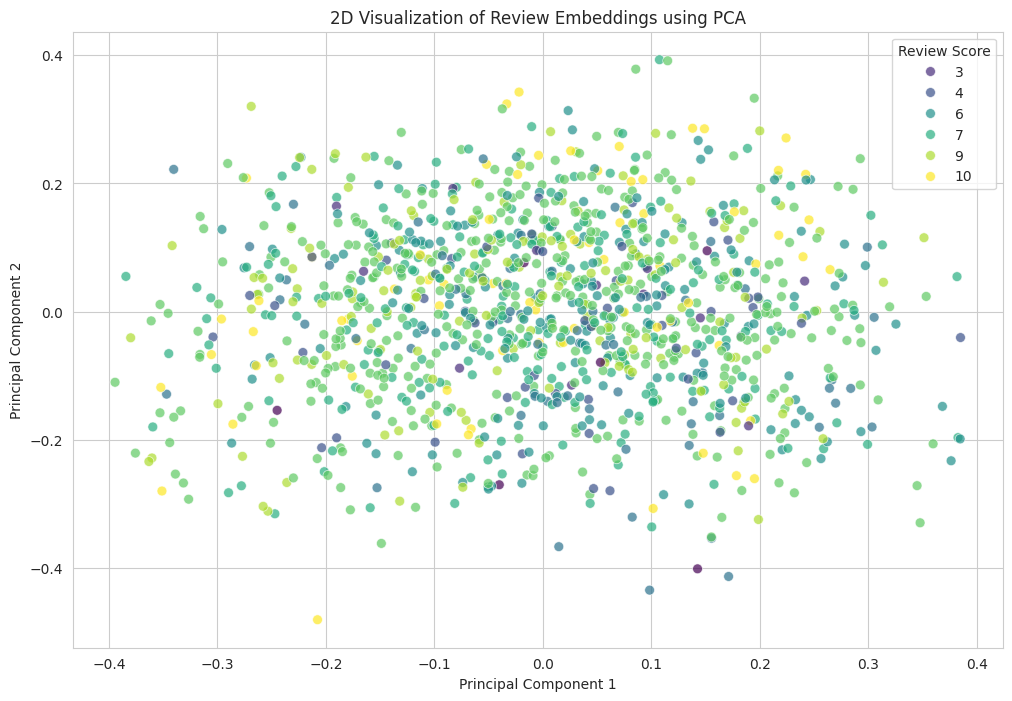

In [ ]:
# Implementation: PCA and Visualization

print("Performing PCA to reduce dimensionality to 2...")
# We will visualize the labeled data to see if scores create clusters.
pca = PCA(n_components=2)
labeled_embeddings_2d = pca.fit_transform(labeled_embeddings_sbert)

# Create a DataFrame for easy plotting
vis_df = pd.DataFrame(labeled_embeddings_2d, columns=['PC1', 'PC2'])
vis_df['score'] = labeled_df['review_score']

print("Plotting the 2D representation of review embeddings...")
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=vis_df,
    x='PC1',
    y='PC2',
    hue='score',
    palette='viridis',  # A color palette that shows progression well
    s=50,  # size of points
    alpha=0.7
)
plt.title('2D Visualization of Review Embeddings using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Review Score')
plt.show()

## 2. Supervised Learning Baselines

In [ ]:
# Define features (X) and target (y)
X = labeled_embeddings_sbert
y = labeled_df['review_score']

# 2.1 Data Split: 80% train, 10% validation, 10% test
# First, split into 80% train and 20% temporary (for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split the 20% temporary set into 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Store baseline results
baseline_results = {}

Training set size: 1000
Validation set size: 125
Test set size: 125



--- Training Classification Baseline ---
Accuracy: 0.3360
Macro F1-Score: 0.0634
Macro Precision: 0.0929
Macro Recall: 0.1104


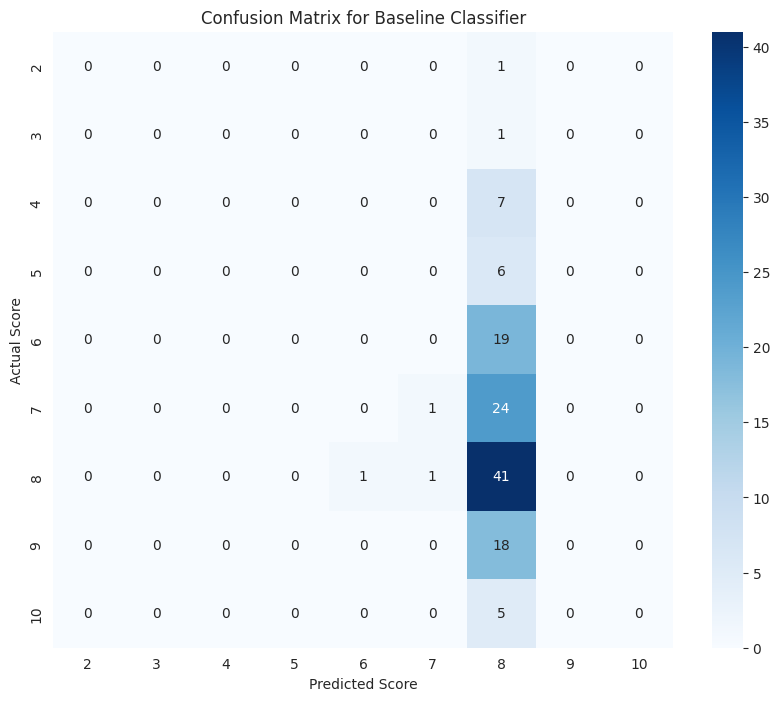

In [ ]:
print("\n--- Training Classification Baseline ---")
# Initialize and train the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_class = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class, average='macro')
precision = precision_score(y_test, y_pred_class, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred_class, average='macro', zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred_class)

baseline_results['Classifier'] = {'Accuracy': accuracy, 'F1-score (macro)': f1}

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {f1:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for Baseline Classifier')
plt.xlabel('Predicted Score')
plt.ylabel('Actual Score')
plt.show()

In [ ]:
print("\n--- Training Regression Baseline ---")
# Initialize and train the regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_reg_continuous = rf_regressor.predict(X_test)

# Round predictions to the nearest integer and clip to the valid range [1, 10]
y_pred_reg = np.round(y_pred_reg_continuous).astype(int)
y_pred_reg = np.clip(y_pred_reg, 1, 10)

# Evaluate the regressor
mae = mean_absolute_error(y_test, y_pred_reg)
mse = mean_squared_error(y_test, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_reg)

baseline_results['Regressor'] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


--- Training Regression Baseline ---
Mean Absolute Error (MAE): 1.1200
Root Mean Squared Error (RMSE): 1.5179
R-squared (R2): 0.0345


## 3. Semi-Supervised Learning (SSL) Strategies

In [ ]:
# --- Implementation: Pseudo-Labeling ---

print("Starting Pseudo-Labeling process...")

# Keep track of performance over iterations
pseudo_labeling_history = []

# Make copies to avoid modifying the original data
X_train_pl = X_train.copy()
y_train_pl = y_train.copy()
unlabeled_pool = unlabeled_embeddings_sbert.copy()

# Set a confidence threshold: we'll accept pseudo-labels if the std dev of tree predictions is low
# This value may need tuning. A lower value means we are more selective.
CONFIDENCE_THRESHOLD = 1
NUM_ROUNDS_PL = 5

current_model = rf_regressor # Start with our baseline model

for i in range(NUM_ROUNDS_PL):
    print(f"\n--- Pseudo-Labeling Round {i+1}/{NUM_ROUNDS_PL} ---")

    if len(unlabeled_pool) == 0:
        print("Unlabeled pool is empty. Stopping.")
        break

    # Step 1 & 2: Predict on unlabeled data and estimate confidence
    # Get predictions from each tree in the forest
    tree_predictions = np.array([tree.predict(unlabeled_pool) for tree in current_model.estimators_])

    # Calculate the mean (the final prediction) and standard deviation (our uncertainty metric)
    mean_predictions = np.mean(tree_predictions, axis=0)
    std_dev_predictions = np.std(tree_predictions, axis=0)

    # Step 3: Select high-confidence samples
    high_confidence_mask = std_dev_predictions < CONFIDENCE_THRESHOLD

    if np.sum(high_confidence_mask) == 0:
        print("No new samples met the confidence threshold. Stopping.")
        break

    # Get the embeddings and pseudo-labels for these samples
    new_X = unlabeled_pool[high_confidence_mask]
    new_y = np.round(mean_predictions[high_confidence_mask]).astype(int)
    new_y = np.clip(new_y, 1, 10)

    print(f"Found {len(new_X)} high-confidence samples to add.")

    # Step 4 & 5: Add pseudo-labeled data to the training set
    X_train_pl = np.vstack([X_train_pl, new_X])
    y_train_pl = np.concatenate([y_train_pl, new_y])

    # Remove the newly labeled data from the unlabeled pool
    unlabeled_pool = unlabeled_pool[~high_confidence_mask]

    # Step 6: Retrain the model
    print("Retraining model on expanded dataset...")
    new_model = RandomForestRegressor(n_estimators=100, random_state=42)
    new_model.fit(X_train_pl, y_train_pl)
    current_model = new_model

    # Step 7: Evaluate
    y_pred_pl = current_model.predict(X_test)
    y_pred_pl_rounded = np.round(y_pred_pl).astype(int)
    y_pred_pl_rounded = np.clip(y_pred_pl_rounded, 1, 10)

    mae = mean_absolute_error(y_test, y_pred_pl_rounded)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_pl_rounded))

    pseudo_labeling_history.append({
        'round': i + 1,
        'total_samples': len(y_train_pl),
        'mae': mae,
        'rmse': rmse
    })

    print(f"Test MAE after round {i+1}: {mae:.4f}")
    print(f"Test RMSE after round {i+1}: {rmse:.4f}")

Starting Pseudo-Labeling process...

--- Pseudo-Labeling Round 1/5 ---
Found 36 high-confidence samples to add.
Retraining model on expanded dataset...
Test MAE after round 1: 1.0880
Test RMSE after round 1: 1.4642

--- Pseudo-Labeling Round 2/5 ---
Found 40 high-confidence samples to add.
Retraining model on expanded dataset...
Test MAE after round 2: 1.1440
Test RMSE after round 2: 1.5153

--- Pseudo-Labeling Round 3/5 ---
Found 80 high-confidence samples to add.
Retraining model on expanded dataset...
Test MAE after round 3: 1.1040
Test RMSE after round 3: 1.5126

--- Pseudo-Labeling Round 4/5 ---
Found 152 high-confidence samples to add.
Retraining model on expanded dataset...
Test MAE after round 4: 1.1680
Test RMSE after round 4: 1.5179

--- Pseudo-Labeling Round 5/5 ---
Found 282 high-confidence samples to add.
Retraining model on expanded dataset...
Test MAE after round 5: 1.1120
Test RMSE after round 5: 1.5047


In [ ]:
# --- Implementation: Active Learning ---

print("\nStarting Active Learning process...")

# We need a pool of data that has labels we can "reveal" to simulate the oracle.
# Let's combine our validation and test sets to form this pool for simulation.
# We will then create a new, final, smaller test set to ensure fair evaluation.
X_pool = np.vstack([X_val, X_test])
y_pool = np.concatenate([y_val, y_test])

# Let's create a small, final held-out test set from our original training data for this simulation.
# This ensures the model never sees the final test data during active learning.
X_train_al_base, X_final_test, y_train_al_base, y_final_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Active learning state
X_train_al = X_train_al_base.copy()
y_train_al = y_train_al_base.copy()

# Keep track of performance
active_learning_history = []
NUM_ROUNDS_AL = 5
SAMPLES_PER_ROUND = 20  # How many samples we "ask the human" to label each round

# Start with a model trained on the smaller base training set
current_model_al = RandomForestRegressor(n_estimators=100, random_state=42)
current_model_al.fit(X_train_al, y_train_al)

for i in range(NUM_ROUNDS_AL):
    print(f"\n--- Active Learning Round {i+1}/{NUM_ROUNDS_AL} ---")

    if len(X_pool) < SAMPLES_PER_ROUND:
        print("Not enough samples left in the pool. Stopping.")
        break

    # Step 1: Compute uncertainty scores for the pool
    tree_predictions_al = np.array([tree.predict(X_pool) for tree in current_model_al.estimators_])
    std_dev_predictions_al = np.std(tree_predictions_al, axis=0)

    # Step 2: Select top-k most uncertain samples
    # argsort returns indices that would sort the array, so we take the last 'k' for the highest values
    uncertain_indices = np.argsort(std_dev_predictions_al)[-SAMPLES_PER_ROUND:]

    # Get the samples to be labeled
    X_to_label = X_pool[uncertain_indices]
    y_to_label = y_pool[uncertain_indices]

    print(f"Selected {len(X_to_label)} most uncertain samples to be labeled.")

    # Step 3 & 4: Simulate annotation and add to training set
    X_train_al = np.vstack([X_train_al, X_to_label])
    y_train_al = np.concatenate([y_train_al, y_to_label])

    # Remove these samples from the pool
    X_pool = np.delete(X_pool, uncertain_indices, axis=0)
    y_pool = np.delete(y_pool, uncertain_indices, axis=0)

    # Step 5: Retrain the model
    print("Retraining model on expanded labeled dataset...")
    new_model_al = RandomForestRegressor(n_estimators=100, random_state=42)
    new_model_al.fit(X_train_al, y_train_al)
    current_model_al = new_model_al

    # Step 6: Evaluate on the final, held-out test set
    y_pred_al = current_model_al.predict(X_final_test)
    y_pred_al_rounded = np.round(y_pred_al).astype(int)
    y_pred_al_rounded = np.clip(y_pred_al_rounded, 1, 10)

    mae = mean_absolute_error(y_final_test, y_pred_al_rounded)
    rmse = np.sqrt(mean_squared_error(y_final_test, y_pred_al_rounded))

    active_learning_history.append({
        'round': i + 1,
        'total_samples': len(y_train_al),
        'mae': mae,
        'rmse': rmse
    })

    print(f"Final Test MAE after round {i+1}: {mae:.4f}")
    print(f"Final Test RMSE after round {i+1}: {rmse:.4f}")


Starting Active Learning process...

--- Active Learning Round 1/5 ---
Selected 20 most uncertain samples to be labeled.
Retraining model on expanded labeled dataset...
Final Test MAE after round 1: 1.0500
Final Test RMSE after round 1: 1.4491

--- Active Learning Round 2/5 ---
Selected 20 most uncertain samples to be labeled.
Retraining model on expanded labeled dataset...
Final Test MAE after round 2: 1.0650
Final Test RMSE after round 2: 1.4474

--- Active Learning Round 3/5 ---
Selected 20 most uncertain samples to be labeled.
Retraining model on expanded labeled dataset...
Final Test MAE after round 3: 1.0350
Final Test RMSE after round 3: 1.4300

--- Active Learning Round 4/5 ---
Selected 20 most uncertain samples to be labeled.
Retraining model on expanded labeled dataset...
Final Test MAE after round 4: 1.0500
Final Test RMSE after round 4: 1.4283

--- Active Learning Round 5/5 ---
Selected 20 most uncertain samples to be labeled.
Retraining model on expanded labeled dataset..

## 4. Comparative Performance Analysis

In [ ]:
# Create DataFrames from the history lists
pl_df = pd.DataFrame(pseudo_labeling_history)
al_df = pd.DataFrame(active_learning_history)

# Baseline regressor performance on the original test set for comparison
baseline_mae = baseline_results['Regressor']['MAE']
baseline_rmse = baseline_results['Regressor']['RMSE']

# Add baseline to the start of each history
baseline_pl = pd.DataFrame([{'round': 0, 'total_samples': len(y_train), 'mae': baseline_mae, 'rmse': baseline_rmse}])
pl_df = pd.concat([baseline_pl, pl_df], ignore_index=True)

# For active learning, we need the baseline on the smaller, final test set
y_pred_base_al = rf_regressor.predict(X_final_test)
y_pred_base_al_rounded = np.round(y_pred_base_al).astype(int).clip(1, 10)
baseline_mae_al = mean_absolute_error(y_final_test, y_pred_base_al_rounded)
baseline_rmse_al = np.sqrt(mean_squared_error(y_final_test, y_pred_base_al_rounded))

baseline_al = pd.DataFrame([{'round': 0, 'total_samples': len(y_train_al_base), 'mae': baseline_mae_al, 'rmse': baseline_rmse_al}])
al_df = pd.concat([baseline_al, al_df], ignore_index=True)


print("--- Performance Summary: Pseudo-Labeling ---")
print(pl_df)

print("\n--- Performance Summary: Active Learning ---")
print(al_df)

--- Performance Summary: Pseudo-Labeling ---
   round  total_samples    mae      rmse
0      0           1000  1.120  1.517893
1      1           1036  1.088  1.464240
2      2           1076  1.144  1.515256
3      3           1156  1.104  1.512614
4      4           1308  1.168  1.517893
5      5           1590  1.112  1.504659

--- Performance Summary: Active Learning ---
   round  total_samples    mae      rmse
0      0            800  0.270  0.565685
1      1            820  1.050  1.449138
2      2            840  1.065  1.447411
3      3            860  1.035  1.430035
4      4            880  1.050  1.428286
5      5            900  1.020  1.431782


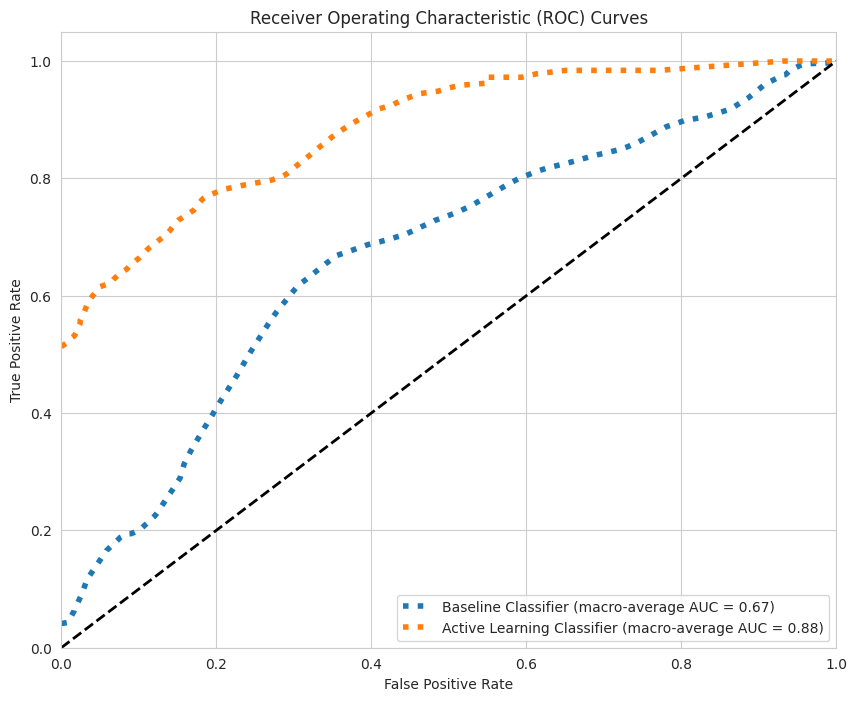

In [ ]:
# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Get prediction probabilities from the baseline classifier
y_score_baseline = rf_classifier.predict_proba(X_test)

# --- Train a new classifier on the final active learning dataset ---
# This demonstrates the improvement from SSL in a classification context
final_al_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# We need integer labels for the classifier training set
y_train_al_int = y_train_al.astype(int)
final_al_classifier.fit(X_train_al, y_train_al_int)
y_score_al = final_al_classifier.predict_proba(X_test) # Evaluate on the original test set


# Function to plot ROC curves
def plot_multiclass_roc(y_true_bin, y_score, model_name, n_classes):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'{model_name} (macro-average AUC = {roc_auc["macro"]:.2f})',
             linestyle=':', linewidth=4)

plt.figure(figsize=(10, 8))
plot_multiclass_roc(y_test_bin, y_score_baseline, "Baseline Classifier", n_classes)
plot_multiclass_roc(y_test_bin, y_score_al, "Active Learning Classifier", n_classes)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

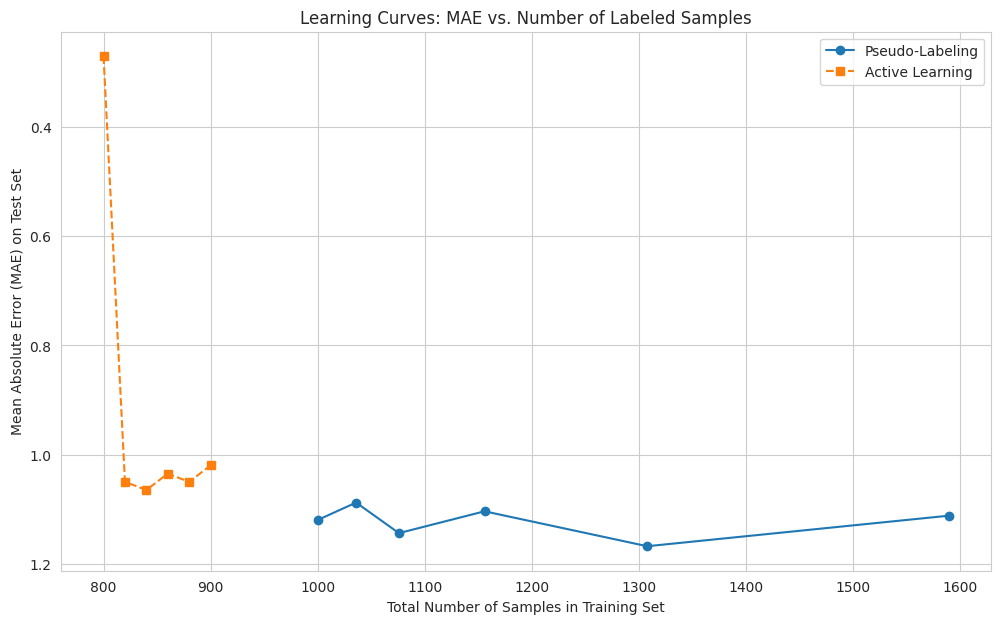

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(pl_df['total_samples'], pl_df['mae'], marker='o', linestyle='-', label='Pseudo-Labeling')
plt.plot(al_df['total_samples'], al_df['mae'], marker='s', linestyle='--', label='Active Learning')

plt.title('Learning Curves: MAE vs. Number of Labeled Samples')
plt.xlabel('Total Number of Samples in Training Set')
plt.ylabel('Mean Absolute Error (MAE) on Test Set')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis() # Lower MAE is better, so we flip the y-axis
plt.show()